# Прогнозирование вероятности оттока пользователей для фитнес-центров

## Описание проекта

Задача

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. 

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами фитнес-центра перевёл в электронный вид множество клиентских анкет. 

Наша задача — провести анализ и подготовить план действий по удержанию клиентов.
А именно:
- прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента; сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

  1) выделить целевые группы клиентов;
  
  2) предложить меры по снижению оттока;
  
  3) определить другие особенности взаимодействия с клиентами.

## Описание данных

Фитнес-центр предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);

* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* 'Churn' — факт оттока в текущем месяце.

## Загрузим данные

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')  

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150 
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
data = pd.read_csv('/file.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [4]:
# поменяем регистр в названии колонок
data.columns = [x.lower() for x in data.columns.values]
# посмотрим и проверим данные, с помощью функции
def inform(df):
    print(df.info())
    print('Пропуски:\n',df.isna().sum())
    print('Дубликаты: ',df.duplicated().sum())
    
inform(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

На первый взгдяд данные в порядке, но вот нет id клиента, кто то может вернулся.

## Проведём исследовательский анализ данных (EDA)

### Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения.

In [5]:
display(data.describe())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Что мы видим:
- Распределение по полу примерно одинаково;
- 85% живет или работает рядом с фитнес-клубом;
- Примерно половина клиентов являются сотрудниками партнерских организаций;
- 31% клиентов пришли по программе "Приведи друга";
- У 90% клиентов известны мобильные номера;
- Средняя длительность абонементов клиентов - 4.7 мес.;
- 41% клиентов посещают групповые занятия;
- Средний возраст клиентов 29 лет;
- Средние дополнительные расходы на клиента - 147;
- Средний срок до окончания договора - 4.3 мес.;
- Среднее время с момента первого обращения в фитнес-центр - 3.7 мес.;
- Средняя частота посещений за все время - 1.88 раз в неделю;
- Средняя частота посещений за последний месяц - 1.77 раз в неделю;
- Доля оттока - 27%.

### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [6]:
display(data.groupby('churn').agg('mean').T)

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Выводы по таблице "отток/ оставшиеся":

- Распределение по полу не отличается;
- Близко живущие или работающие клиенты чуть реже попадают в отток;
- Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб;
- Пришедшие по акции "Приведи друга" почти в два раза реже попадают в отток;
- Наличие мобильного номера клиента не влияет на отток, одинаково в обих группах;
- Средняя длительность договора существенно больше у оставшихся клиентов, у клиентов в оттоке срок договора чаще составляет 1 месяц;
- Оставшиеся клиенты чаще ходят на групповые занятия;
- Есть небольшая разница в среднем возрасте клиентов;
- Есть небольшое разница в выручке от доп. услуг фитнес-центра;
- Оставшееся время до окончания срока действия договора логично больше у оставшихся клиентов;
- Количество посещений в неделю за все время в два раза ниже у клиентов в оттоке;
- Количество посещений в предыдущий месяц в два раза ниже у клиентов в оттоке.

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

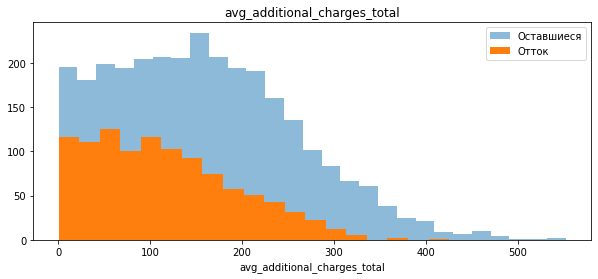

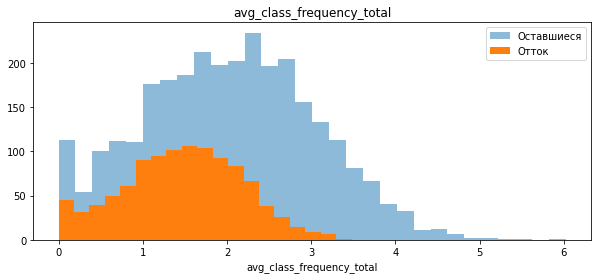

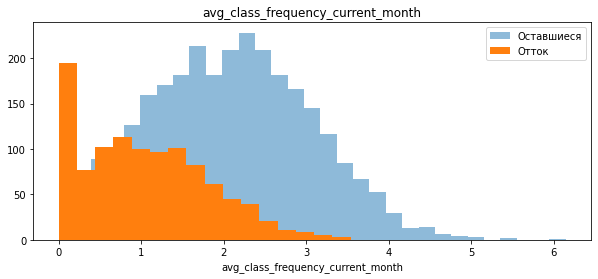

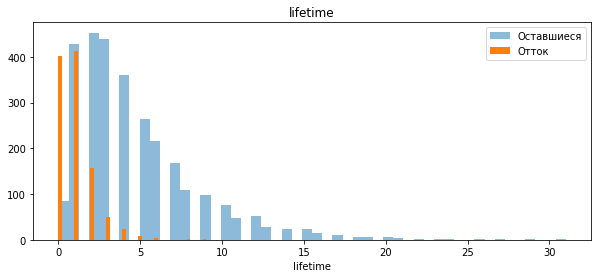

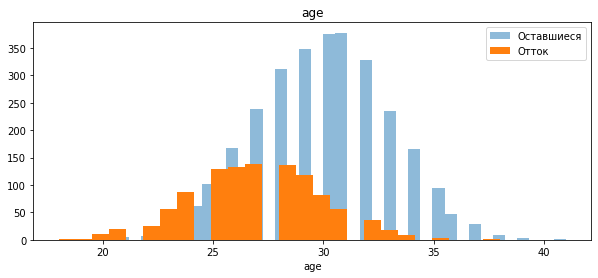

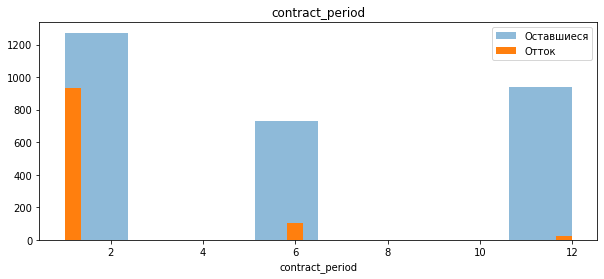

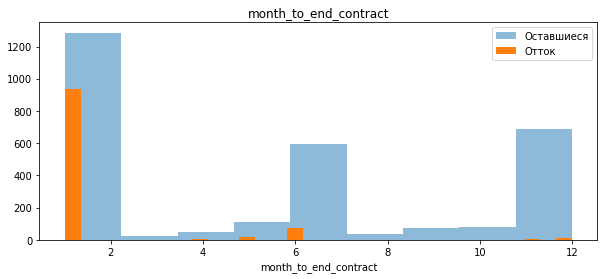

In [7]:
outflow = data[data['churn'] == 1]
remaining = data[data['churn'] == 0]

distplot_columns = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']

for column in distplot_columns: 
    plt.figure(figsize=(10,4)) 
    plt.title(column)
    sns.distplot(remaining[column], kde=False, hist_kws={"alpha": 0.5})
    sns.distplot(outflow[column], kde=False, hist_kws={"alpha": 1})
    plt.legend(['Оставшиеся', 'Отток'])
    plt.show()

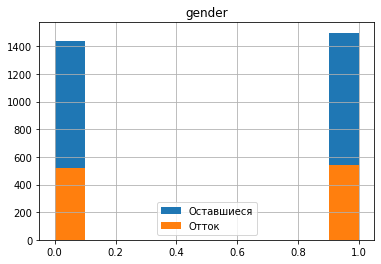

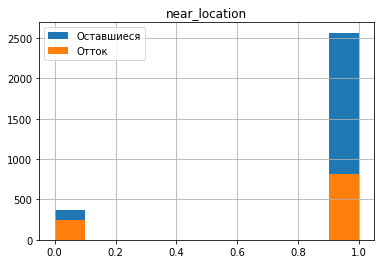

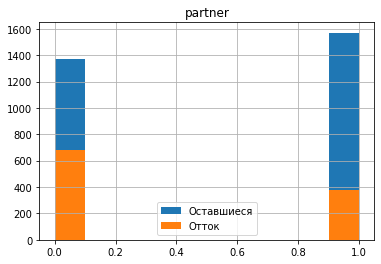

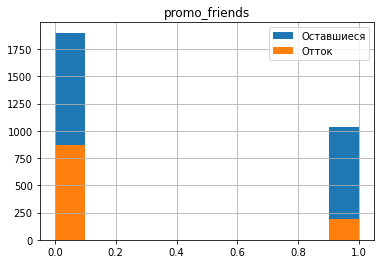

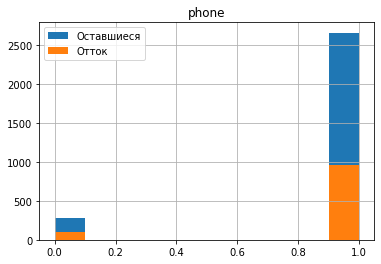

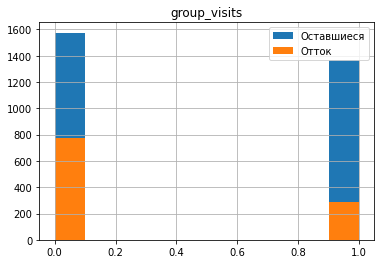

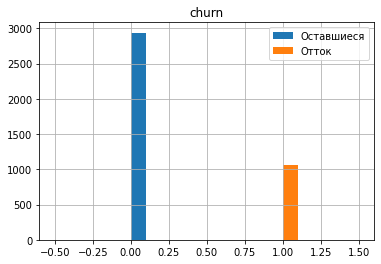

In [8]:
for column in data.columns:
    if column not in distplot_columns:
        data.groupby('churn')[column].hist(alpha = 1)
        plt.title(column)
        plt.legend(['Оставшиеся', 'Отток'])
        plt.show()

### Построим матрицу корреляций и отобразим её.

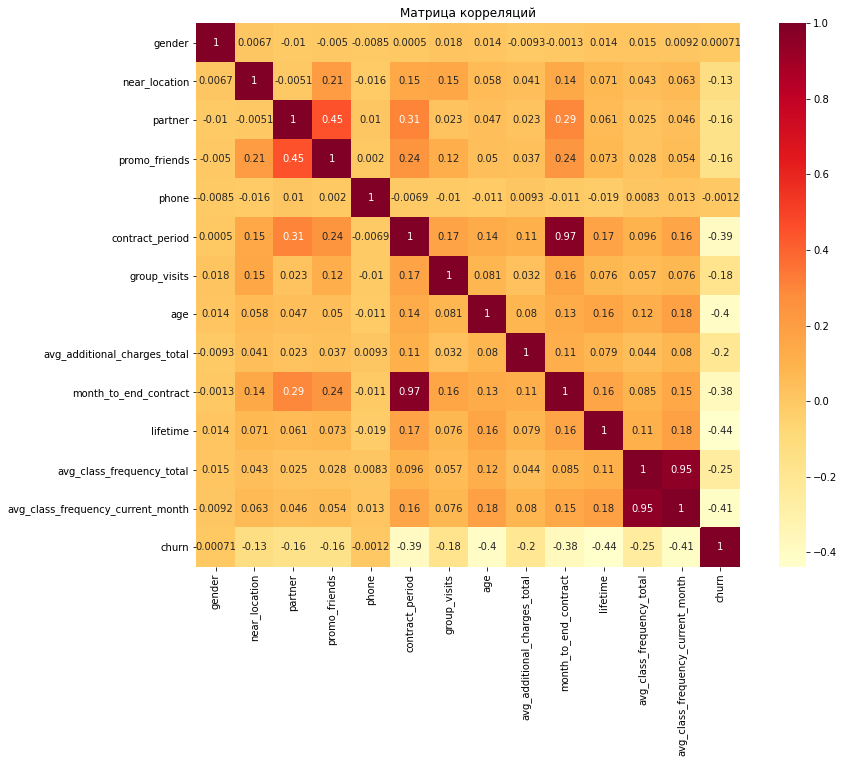

In [9]:
plt.figure(figsize=(14,10))
sns.heatmap(data = data.corr(), annot=True, square=True, cmap='YlOrRd')
plt.title('Матрица корреляций')
plt.show()

Вывод: 
1. Мультиколлинеарные признаки:
  - contract_period и month_to_end_contract;
  - avg_class_frequency_current_month и avg_class_frequency_total.
2. Признаки с нулевой важностью:
  - phone;
  - gender

In [10]:
# Удалим по одному из пары мультьиколлинеарных признаков
data = data.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis = 1)

## Построим модель прогнозирования оттока клиентов

### Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

#### Разобъем данные на обучающую и валидационную выборку функцией train_test_split().

In [11]:
X = data.drop(['churn'], axis = 1)
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()

X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

#### Обучим модель на train-выборке двумя способами: 
- логистической регрессией,
- случайным лесом.

In [12]:
# Логистическая регрессия
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

print('Метрики для модели логистической регрессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, lr_predictions)))

Метрики для модели логистической регрессии:
Accuracy: 0.90
Precision: 0.79
Recall: 0.81
F1: 0.80


In [13]:
# Случайный лес
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

print('Метрики для модели случайного леса:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Метрики для модели случайного леса:
Accuracy: 0.89
Precision: 0.79
Recall: 0.76
F1: 0.77


#### Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?

Модель Логистическая регрессия показала себя лучше на основании метрик Precision и  Recall.

## Сделаем кластеризацию клиентов

Отложим в сторону столбец с оттоком и проведём кластеризацию объектов (клиентов):

### Стандартизируем данные.

In [14]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. 

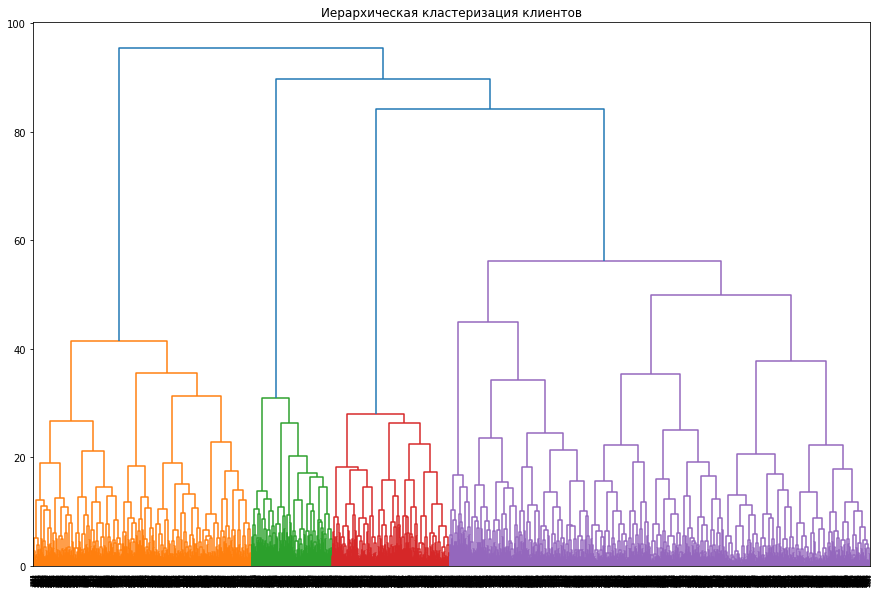

In [15]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов')
plt.show()

Выделяется 4 кластера

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 
Договоримся за число кластеров принять n=5, чтобы наши результаты можно было сравнивать с результатами остальных студентов.

In [16]:
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров
data['cluster_km'] = labels

### Посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [17]:
data.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.50,0.49,0.51,0.54,0.52
near_location,0.00,1.00,1.00,1.00,0.86
partner,0.49,0.96,0.24,0.25,0.47
promo_friends,0.08,0.89,0.06,0.08,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,3.03,7.66,2.82,4.53,4.78
group_visits,0.24,0.46,0.00,1.00,0.43
age,28.72,29.54,28.77,29.54,29.30
avg_additional_charges_total,137.54,155.86,143.38,148.09,144.21
lifetime,3.06,4.38,3.34,3.76,3.94


- Кластер 0:
  - Отток - 40% самый большой
  - живут не рядом
  - Самая молодая аудитория
  - Самая маленькая выручка по доп. услугам
  - Самое короткое время с момента первого обращения в фитнес-центр - 3.06
  - Самая низкая частота посещений - 1.77
- Кластер 1:
  - Отток - 12% самый маленький
  - Все живут рядом
  - Больше всего сотрудников компании-партнёра клуба
  - Больше всего по промо акции "приведи друга"
  - Длительность текущего действующего абонемента 7.66 мес - самый большой показатель
  - Любят групповые занятия
  - Самая большая выручка от доп. услуг
  - Самое длительное время с момента первого обращения в фитнес-центр - 4.38
  - Самая высокая частота посещений
- Кластер 2:
  - Отток - 38%
  - Меньше всего сотрудников компании-партнёра клуба
  - Меньше всего по промо акции "приведи друга"
  - Длительность текущего действующего абонемента 2.82 мес - самый низкий показатель
  - не посещают групповые занятия
- Кластер 3:
  - Отток - 20%
  - Все ходят на групповые занятия
- Кластер 4:
  - Отток - 27% 
  - Остальные показатели средние


### Построим распределения признаков для кластеров. 

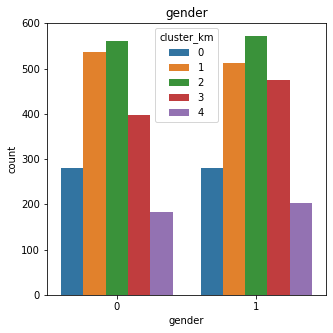

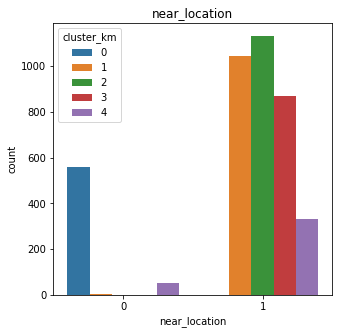

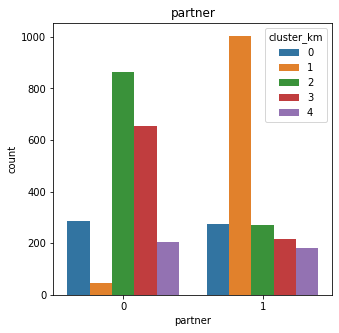

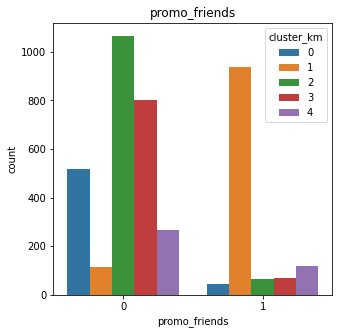

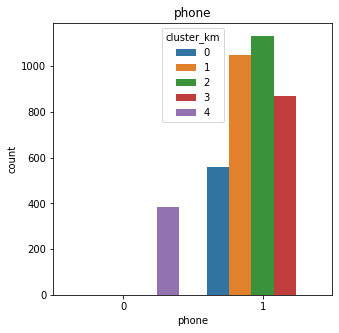

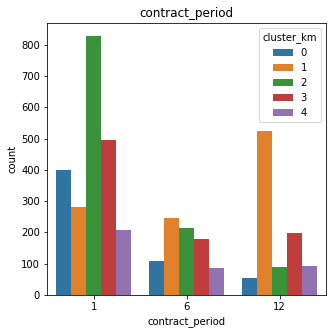

In [18]:

for column in ['gender', 
               'near_location', 
               'partner', 
               'promo_friends',
               'phone',
               'contract_period']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = data[column], hue='cluster_km', data=data)
    plt.title(column)
    plt.show()

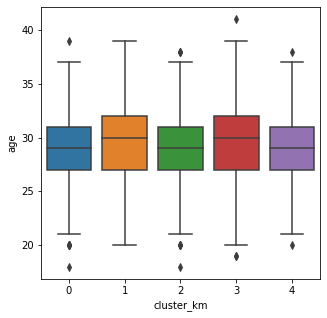

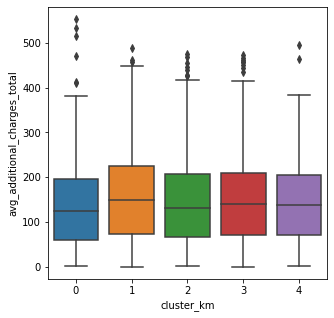

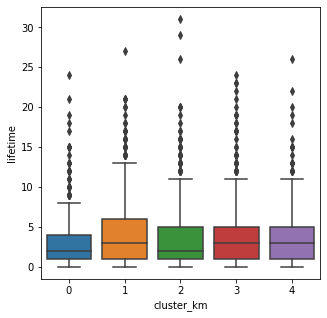

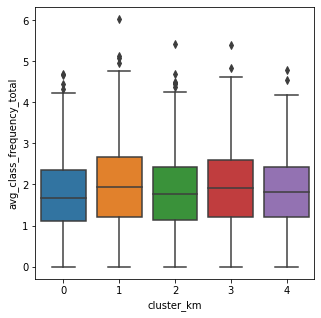

In [19]:
for column in ['age', 
               'avg_additional_charges_total', 
               'lifetime', 
               'avg_class_frequency_total', 
               ]:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x = 'cluster_km', y = data[column], data=data)
    plt.show()

Выводы: 
- Гендер распределен в классетрах примерно одинаково
- Во всех класстерах клиенту живут рядом, кроме кластера 0
- В кластере 1 почти все сотрудники компании-партнера, а в кластерах 2 и 3 наоброт
- По акции "Приведи друга" ситауция повторяется ( в 1 кластере почти все, а в кластерах 2 и 3 почти никто)
- В кластере 4 клиенты без номера телефона
- Длительность текущего действующего абонемента: в кластере 2 больше всего клиентов с коротким сроком - месяц, а вот в кластере 1 больше клиентов со сроком - год
- Возраст у клиентов в целом одинаков
- Выручка больше в кластере 1, а меньше всех в кластере 0
- Время с момента первого обращения в фитнес-центр:
  - Кластер 1 - саое длинное
  - Кластер 2 - самое низкое (примерно 1 месяц)
  - Остальные кластеры в среднем одинаковы (примерно 3 месяца)
- Средняя частота посещений в неделю за все время:
  - Кластер 1 - самая высокая (примерно 2 и более раза)
  - Кластер 0 - самая низкая (примерно 1 раз)
  - Остальные кластеры в среднем одинаковы (примерно 2 раза)

### Для каждого полученного кластера посчитаем долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [20]:
cluster_outflow = (data.groupby('cluster_km')['churn'].sum()/ len(data)*100).round(2).astype(str) + '%'
cluster_outflow

cluster_km
0     5.6%
1    3.18%
2    10.8%
3    4.38%
4    2.58%
Name: churn, dtype: object

Вывод:
- В 4 кластере - отток самый низкий
- В 2 кластере - отток самый большой

Поэтому надежными можно назвать  1 и 4 кластеры, остальные требуют внимания осбенно 2 кластер.

## Выводы и  базовые рекомендации по работе с клиентами:

Выводы:

EDA нам показало:
- Признак "пол" - не влияет
- Ближе живущие/ работающие клиенты меньше попадают в отток
- Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб
- Клиенты, пришедшие по акции "Приведи друга" намного реже уходят в отток
- Наличие мобильного номера клиента - не влияет
- Длительность текущего действующего абонемента равна обычно 1 месяцу у клиентов в оттоке
- Клиенты попавшие в отток обычно не посещают групповые занятие, что логично( они просто не успевают)
- Клиенты от 25 до 30 лет чаще оказываются в оттоке
- Lifetime показывает, что люди обычно определяются в первые 3 месяца, ходить дальше или нет.
- Среднее посещение в неделю у клиентов в отттоке за месяц иили за все время равно 1

Модель прогнозирования Логистическая регрессия показала себя лучше на основании метрик Precision и Recall.

Кластеризация клиентов
- Выделяется 4 кластера, но в этом задании мы использовали 5 кластеров
- Высокий отток в кластерах 0, 2 и 3

Рекомендации:
- Во первых более глубже изучить кластеры 0, 2 и 3, чтобы снизить отток (узанть дополнительные признаки)
- Т.к. отток клиентов в каком то проценте все равно будет, то было бы не плохо это пперекрывать рекламмой на целенной на аудиторию с признаками из оставшихся.
- Может быть стоит добавить абонемент на 3 месяца (он мог бы увеличить выручку с тех кто определяется)
